In [1]:
import json
import os
import random
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

### 1. Data preprocessing
+ 1.1 observation and cleaning
+ 1.2 splitting
+ 1.3 numpy or dataloader

+ download: [Kaggle link](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset/data)
+ info:
    + columns:
        0. CRIM - per capita crime rate by town
        1. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
        2. INDUS - proportion of non-retail business acres per town.
        3. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
        4. NOX - nitric oxides concentration (parts per 10 million)
        5. RM - average number of rooms per dwelling
        6. AGE - proportion of owner-occupied units built prior to 1940
        7. DIS - weighted distances to five Boston employment centres
        8. RAD - index of accessibility to radial highways
        9. TAX - full-value property-tax rate per \$10,000
        10. PTRATIO - pupil-teacher ratio by town
        11. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        12. LSTAT - % lower status of the population
        13. MEDV - Median value of owner-occupied homes in $1000's
    +  13 inputs -> 1 output (last columns)
+ more reference:
    + [Python 快速資料分析：Boston Housing波士頓房價](https://medium.com/li-ting-liao-tiffany/python-%E5%BF%AB%E9%80%9F%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-boston-housing%E6%B3%A2%E5%A3%AB%E9%A0%93%E6%88%BF%E5%83%B9-9c535fb7ceb7)

In [2]:
# load dataset
df = pd.read_csv("./housing.csv")
df

,0.00632 18.00 2.310 0 0.5380 6.5750 65.20 4.0900 1 296.0 15.30 396.90 4.98 24.00
0,0.02731 0.00 7.070 0 0.4690 6.4210 78...
1,0.02729 0.00 7.070 0 0.4690 7.1850 61...
2,0.03237 0.00 2.180 0 0.4580 6.9980 45...
3,0.06905 0.00 2.180 0 0.4580 7.1470 54...
4,0.02985 0.00 2.180 0 0.4580 6.4300 58...
...,...
500,0.06263 0.00 11.930 0 0.5730 6.5930 69...
501,0.04527 0.00 11.930 0 0.5730 6.1200 76...
502,0.06076 0.00 11.930 0 0.5730 6.9760 91...
503,0.10959 0.00 11.930 0 0.5730 6.7940 89...


In [3]:
# format dataset
dataset = []
with open("./housing.csv", "r") as f:
    for line in f.readlines():
        line_split_list = line.split(" ")
        line_split_list = [line_split for line_split in line_split_list if line_split]
        line_split_list = [float(line_split.replace("\n", "")) for line_split in line_split_list]
        assert len(line_split_list) == 14
        dataset.append(line_split_list)
dataset = pd.DataFrame(dataset)
dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [4]:
# check for missing values
dataset.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
dtype: int64

In [5]:
# filter outliers
std_multiple = 3

dataset_mask = dataset.copy().astype(bool)
for col in dataset.columns:
    mean = dataset[col].mean()
    std = dataset[col].std()
    dataset_mask[col] = np.abs(dataset[col] - mean) / std < std_multiple
print("keep_rate_of_each_column:\n", dataset_mask.sum(axis=0) / len(dataset_mask))

row_mask = dataset_mask.all(axis=1)
print("keep_rate_of_all_data:\n", row_mask.sum() / len(row_mask))

dataset = dataset[row_mask]
dataset

keep_rate_of_each_column:
 0     0.984190
1     0.972332
2     1.000000
3     0.930830
4     1.000000
5     0.984190
6     1.000000
7     0.990119
8     1.000000
9     1.000000
10    1.000000
11    0.950593
12    0.990119
13    1.000000
dtype: float64
keep_rate_of_all_data:
 0.8201581027667985


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


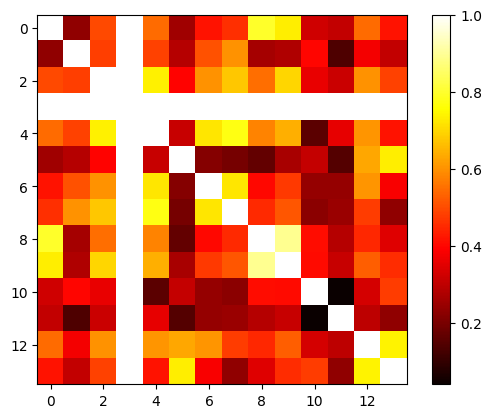

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.000000,0.235368,0.496014,NaN,0.543941,0.256220,0.419317,0.458391,0.797353,0.731316,0.322394,0.306526,0.543535,0.418531
1,0.235368,1.000000,0.482283,NaN,0.484217,0.285338,0.507627,0.601974,0.265506,0.277640,0.400607,0.141924,0.377615,0.306172
2,0.496014,0.482283,1.000000,NaN,0.734989,0.395686,0.599328,0.675009,0.548687,0.699422,0.361641,0.316034,0.601658,0.486369
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.543941,0.484217,0.734989,NaN,1.000000,0.311671,0.719230,0.772557,0.579036,0.644144,0.160670,0.356332,0.604435,0.417222
5,0.256220,0.285338,0.395686,NaN,0.311671,1.000000,0.219932,0.195682,0.171454,0.269194,0.309908,0.146503,0.630955,0.734041
6,0.419317,0.507627,0.599328,NaN,0.719230,0.219932,1.000000,0.719924,0.403405,0.474359,0.242456,0.242556,0.603143,0.384446
7,0.458391,0.601974,0.675009,NaN,0.772557,0.195682,0.719924,1.000000,0.450038,0.514232,0.227957,0.250530,0.478924,0.234420
8,0.797353,0.265506,0.548687,NaN,0.579036,0.171454,0.403405,0.450038,1.000000,0.892011,0.408510,0.285008,0.448428,0.347297
9,0.731316,0.277640,0.699422,NaN,0.644144,0.269194,0.474359,0.514232,0.892011,1.000000,0.404856,0.314385,0.526334,0.453723


In [6]:
# correlation analysis
corr = dataset.corr().abs()

plt.imshow(corr, cmap="hot")
plt.colorbar()
plt.show()

corr

In [7]:
# filter columns
dataset = dataset.drop(columns=[3])
dataset

,0,1,2,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [8]:
# normalization
dataset_describe = dataset.describe()
dataset_describe

,0,1,2,4,5,6,7,8,9,10,11,12,13
count,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000
mean,2.452461,9.602410,10.829687,0.547168,6.267554,67.384337,3.852640,8.684337,393.853012,18.467952,374.235373,12.275976,22.353976
std,4.897241,19.677404,6.798613,0.110428,0.611602,28.072043,1.964763,8.196802,161.196133,2.137611,51.582784,6.474602,8.077366
min,0.006320,0.000000,0.460000,0.385000,4.368000,2.900000,1.169100,1.000000,188.000000,12.600000,83.450000,1.730000,5.600000
25%,0.081005,0.000000,5.130000,0.449000,5.886000,43.550000,2.203200,4.000000,279.000000,17.400000,377.880000,7.210000,17.550000
50%,0.211610,0.000000,8.560000,0.524000,6.193000,73.900000,3.377900,5.000000,315.000000,19.000000,392.630000,11.220000,21.200000
75%,2.152115,12.500000,18.100000,0.609000,6.559500,93.700000,5.287300,8.000000,437.000000,20.200000,396.900000,16.215000,24.800000
max,28.655800,80.000000,27.740000,0.871000,8.337000,100.000000,9.222900,24.000000,711.000000,21.200000,396.900000,31.990000,50.000000


In [9]:
dataset_describe.to_csv(os.path.join(output_dir, "dataset_describe.csv"))

# keep raw data
dataset_norm = (dataset - dataset_describe.loc["mean"]) / dataset_describe.loc["std"]
dataset_norm

,0,1,2,4,5,6,7,8,9,10,11,12,13
0,-0.499494,0.426763,-1.253151,-0.083020,0.502689,-0.077812,0.120809,-0.937480,-0.607043,-1.482006,0.439384,-1.126861,0.203782
1,-0.495208,-0.487992,-0.553008,-0.707864,0.250892,0.410218,0.567224,-0.815481,-0.942039,-0.312476,0.439384,-0.484350,-0.093344
2,-0.495212,-0.487992,-0.553008,-0.707864,1.500070,-0.223865,0.567224,-0.815481,-0.942039,-0.312476,0.360481,-1.273588,1.528472
3,-0.494174,-0.487992,-1.272272,-0.807476,1.194315,-0.768891,1.124594,-0.693482,-1.066111,0.108555,0.395377,-1.441938,1.367528
4,-0.486685,-0.487992,-1.272272,-0.807476,1.437938,-0.469661,1.124594,-0.693482,-1.066111,0.108555,0.439384,-1.072804,1.714176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.487995,-0.487992,0.161844,0.233930,0.532120,0.061116,-0.699341,-0.937480,-0.749726,1.184522,0.344197,-0.402492,0.005698
502,-0.491540,-0.487992,0.161844,0.233930,-0.241258,0.331848,-0.796605,-0.937480,-0.749726,1.184522,0.439384,-0.493617,-0.217147
503,-0.488377,-0.487992,0.161844,0.233930,1.158344,0.841252,-0.857681,-0.937480,-0.749726,1.184522,0.439384,-1.024924,0.191402
504,-0.478406,-0.487992,0.161844,0.233930,0.860765,0.780694,-0.744996,-0.937480,-0.749726,1.184522,0.372501,-0.895186,-0.043823


In [10]:
# splitting

seed = 0
random.seed(seed)

n_train = int(len(dataset) * 0.8)
train_indices = random.sample(list(range(len(dataset))), n_train)
valid_indices = list(set(range(len(dataset))) - set(train_indices))

train_dataset = dataset.iloc[train_indices]
valid_dataset = dataset.iloc[valid_indices]
train_dataset_norm = dataset_norm.iloc[train_indices]
valid_dataset_norm = dataset_norm.iloc[valid_indices]

train_dataset_norm.shape, valid_dataset_norm.shape

((332, 13), (83, 13))

In [11]:
train_x = train_dataset_norm.iloc[:, :-1].to_numpy()
train_y = train_dataset_norm.iloc[:, -1:].to_numpy()
valid_x = valid_dataset_norm.iloc[:, :-1].to_numpy()
valid_y = valid_dataset_norm.iloc[:, -1:].to_numpy()

train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((332, 12), (332, 1), (83, 12), (83, 1))

In [12]:
class ToyRegressionDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        """
        Args:
            x (np.ndarray): shape = (num_data, num_input_features)
            y (torch.Tensor): shape = (num_data, num_output_features)
        """
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            x (torch.Tensor): shape = (num_input_features,)
            y (torch.Tensor): shape = (num_output_features,)
        """
        return self.x[index], self.y[index]


trainset = ToyRegressionDataset(train_x, train_y)
validset = ToyRegressionDataset(valid_x, valid_y)
trainset[0]

(tensor([-0.4166, -0.4880, -0.6810, -0.3909,  1.4641,  0.4458, -0.3242, -0.0835,
         -0.5388, -0.4996, -0.0418, -0.9137]),
 tensor([1.1447]))

In [13]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, pin_memory=False, shuffle=False)
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=False, shuffle=False)

### 2. Model prepatation
+ 2.1 model
+ 2.2 loss
+ 2.3 more hyperparameters

In [ ]:
# model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
class ToyRegressionDNN(torch.nn.Module):
    def __init__(
            self,
            num_input_features: int,
            num_output_features: int,
            hidden_size: int = 64
        ):
        super().__init__()
        self.dense1  = torch.nn.Linear(num_input_features, hidden_size)
        self.dense2  = torch.nn.Linear(hidden_size, hidden_size)
        self.dense3  = torch.nn.Linear(hidden_size, num_output_features)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (batch_size, num_input_features)
        Returns:
            x (torch.Tensor): shape = (batch_size, num_output_features)
        """
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        return x


num_input_features = len(trainset[0][0])
num_output_features = len(trainset[0][1])
model = ToyRegressionDNN(num_input_features, num_output_features).to(device)
print(model)
print("num_parameters:", sum(p.numel() for p in model.parameters()))
example_x = trainset[0][0].unsqueeze(0).to(device)
print(model(example_x).shape)

ToyRegressionDNN(
  (dense1): Linear(in_features=12, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=64, bias=True)
  (dense3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)
num_parameters: 5057


In [15]:
# loss
loss_func = torch.nn.MSELoss()

# more hyperparama
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
save_ckpts_per_epochs = 30

### 3. Training
+ 3.1 epoch: train loop, valid loop, save ckpts and loss
+ 3.2 check convergence

In [ ]:
history = {"train_loss_list": [], "valid_loss_list": []}
for epoch in tqdm(range(epochs)):
    # training loop
    train_loss= 0.
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()      # 1. zero the parameter gradients
        pred = model(x)            # 2. f(x) and f'(x)
        loss = loss_func(pred, y)  # 3. compute loss
        loss.backward()            # 4. send loss to torch
        optimizer.step()           # 5. update model parameters by torch loss 
        train_loss += loss.item() / len(trainset)
        
    # validation
    valid_loss = 0.
    for x, y in validloader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_func(pred, y)
            valid_loss += loss.item() / len(validset)
            
    # save
    history["train_loss_list"].append(train_loss)
    history["valid_loss_list"].append(valid_loss)
    with open(os.path.join(output_dir, "history.json"), "w") as f:
        json.dump(history, f, indent=4)
    if valid_loss == min(history["valid_loss_list"]):
        torch.save(model.state_dict(), os.path.join(output_dir, "best.pt"))
    elif (epoch + 1) % save_ckpts_per_epochs == 0:
        torch.save(
            model.state_dict(),
            os.path.join(output_dir, f"epoch_{str(epoch).zfill(3)}.pt")
        )

100%|██████████| 100/100 [00:03<00:00, 32.30it/s]


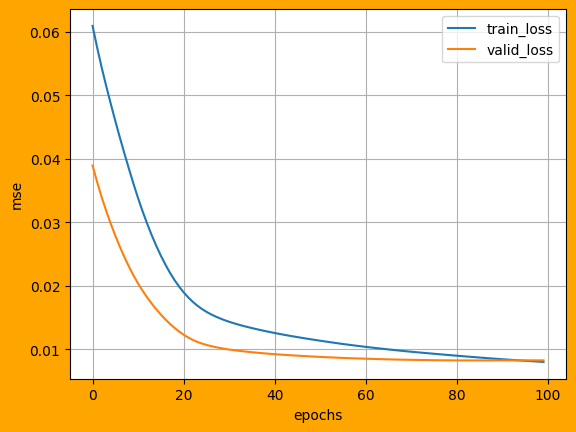

In [17]:
# check convergence
history = json.load(open(os.path.join(output_dir, "history.json")))
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['train_loss_list'], label='train_loss')
plt.plot(history['valid_loss_list'], label='valid_loss')
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

### 4. Prediction
+ 4.1 testset
+ 4.2 (optional) metrics
+ 4.3 (optional) data improvement

In [ ]:
# load checkpoints and inference

ckpt_path = os.path.join(output_dir, "best.pt")
train_dataset_result = train_dataset.copy()
trainloader = trainloader
valid_dataset_result = valid_dataset.copy()
validloader = validloader

model = ToyRegressionDNN(num_input_features, num_output_features).to(device)
model.load_state_dict(torch.load(ckpt_path))
model.eval()
loss_func = torch.nn.MSELoss(reduction="none")

for dataset_result, loader, name in [
        (train_dataset_result, trainloader, "train"),
        (valid_dataset_result, validloader, "valid")
    ]:
    prediction_list = []
    loss_list = []
    for x, y in loader:
        with torch.no_grad():
            pred = model(x)
            loss = loss_func(pred, y)
            prediction_list.append(pred.cpu().numpy().squeeze())  # (B, 1) -> (B,)
            loss_list.append(loss.cpu().numpy().squeeze())  # (B, 1) -> (B,)
    dataset_result["pred"] = np.concatenate(prediction_list)
    dataset_result["loss"] = np.concatenate(loss_list)
    dataset_result.to_csv(os.path.join(output_dir, f"{name}_dataset_result.csv"))
    print(dataset_result)

            0     1      2      4      5     6       7     8      9    10  \
227   0.41238   0.0   6.20  0.504  7.163  79.9  3.2157   8.0  307.0  17.4   
479  14.33370   0.0  18.10  0.614  6.229  88.0  1.9512  24.0  666.0  20.2   
247   0.19657  22.0   5.86  0.431  6.226  79.2  8.0555   7.0  330.0  19.1   
20    1.25179   0.0   8.14  0.538  5.570  98.1  3.7979   4.0  307.0  21.0   
136   0.32264   0.0  21.89  0.624  5.942  93.5  1.9669   4.0  437.0  21.2   
..        ...   ...    ...    ...    ...   ...     ...   ...    ...   ...   
105   0.13262   0.0   8.56  0.520  5.851  96.7  2.1069   5.0  384.0  20.9   
5     0.02985   0.0   2.18  0.458  6.430  58.7  6.0622   3.0  222.0  18.7   
238   0.08244  30.0   4.93  0.428  6.481  18.5  6.1899   6.0  300.0  16.6   
26    0.67191   0.0   8.14  0.538  5.813  90.3  4.6820   4.0  307.0  21.0   
501   0.06263   0.0  11.93  0.573  6.593  69.1  2.4786   1.0  273.0  21.0   

         11     12    13      pred      loss  
227  372.08   6.36  31.6  1.

In [ ]:
# (optional) metrics

ckpt_path = os.path.join(output_dir, "best.pt")
train_x_tensor = torch.tensor(train_x, dtype=torch.float32).to(device)

model = ToyRegressionDNN(num_input_features, num_output_features).to(device)
model.load_state_dict(torch.load(ckpt_path))
model.eval()

explainer = shap.DeepExplainer(model, train_x_tensor)
shap_values = explainer.shap_values(train_x_tensor, check_additivity=False)
shap_values.shape

(332, 12, 1)

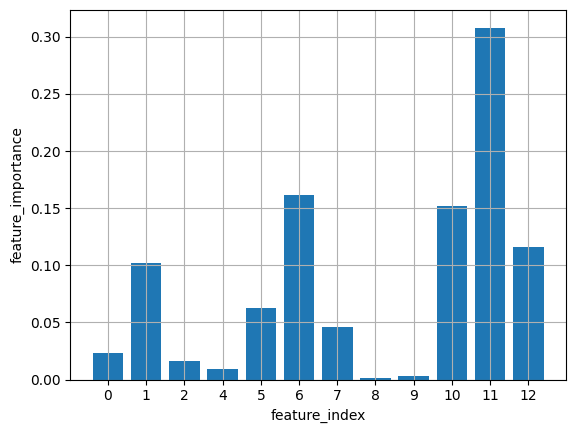

In [27]:
feature_importance = np.abs(shap_values.mean(axis=0)).reshape(-1)
feature_importance = feature_importance / feature_importance.sum()

plt.bar(range(len(feature_importance)), feature_importance)
plt.ylabel("feature_importance")
plt.xlabel("feature_index")
plt.xticks(range(len(feature_importance)), train_dataset.columns[:-1])
plt.grid()
plt.show()

In [28]:
# (optional) data improvement

df = pd.read_csv(os.path.join(output_dir, "train_dataset_result.csv"))
df.rename(columns={"Unnamed: 0": "raw_data_index"}, inplace=True)
df

,raw_data_index,0,1,2,4,5,6,7,8,9,10,11,12,13,pred,loss
0,227,0.41238,0.0,6.20,0.504,7.163,79.9,3.2157,8.0,307.0,17.4,372.08,6.36,31.6,1.489050,0.118589
1,479,14.33370,0.0,18.10,0.614,6.229,88.0,1.9512,24.0,666.0,20.2,383.32,13.11,21.4,-0.296251,0.031736
2,247,0.19657,22.0,5.86,0.431,6.226,79.2,8.0555,7.0,330.0,19.1,376.14,10.15,20.5,-0.324347,0.008991
3,20,1.25179,0.0,8.14,0.538,5.570,98.1,3.7979,4.0,307.0,21.0,376.57,21.02,13.6,-0.923291,0.025752
4,136,0.32264,0.0,21.89,0.624,5.942,93.5,1.9669,4.0,437.0,21.2,378.25,16.90,17.4,-0.692452,0.006263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,105,0.13262,0.0,8.56,0.520,5.851,96.7,2.1069,5.0,384.0,20.9,394.05,16.47,19.5,-0.529874,0.031168
328,5,0.02985,0.0,2.18,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7,0.283684,0.251975
329,238,0.08244,30.0,4.93,0.428,6.481,18.5,6.1899,6.0,300.0,16.6,379.41,6.36,23.7,0.475397,0.095330
330,26,0.67191,0.0,8.14,0.538,5.813,90.3,4.6820,4.0,307.0,21.0,376.88,14.81,16.6,-0.738470,0.000682


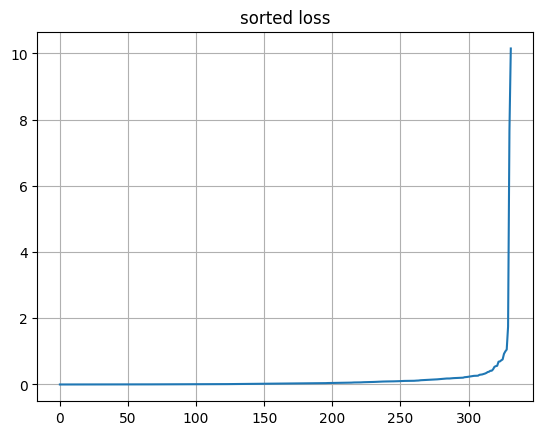

In [29]:
df_loss_sort = df.sort_values("loss")
plt.plot(df_loss_sort["loss"].values)
plt.title("sorted loss")
plt.grid()
plt.show()

In [31]:
print(df_loss_sort[df_loss_sort["loss"] > 1.5]["raw_data_index"].tolist())

[181, 368, 371]
